In [ ]:
import os
from google.colab import drive
import random
import glob
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import itertools

# 1 Configuring Kaggle

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

In [ ]:
!rm -fr ./data

In [ ]:
!kaggle datasets download -d pratik2901/multiclass-weather-dataset --unzip

 97% 89.0M/91.4M [00:00<00:00, 103MB/s]
100% 91.4M/91.4M [00:00<00:00, 98.4MB/s]


### 1.1 Organizing data

In [ ]:
os.mkdir("./data")
!mv Multi-class\ Weather\ Dataset ./data/weather_dataset

In [ ]:
count = 1
for folder_name in os.listdir("./data/weather_dataset/"):
  for file_name in os.listdir(f"./data/weather_dataset/{folder_name}/"):
    source = f"./data/weather_dataset/{folder_name}/{file_name}"

    destination = f"./data/weather_dataset/{folder_name}/pic.{str(count)}.jpg"

    os.rename(source, destination)
    count += 1

os.listdir("./data/weather_dataset/Cloudy")

In [ ]:
os.chdir("./data/weather_dataset")
if os.path.isdir("/train/Cloudy") is False:
  os.makedirs("train/Cloudy")
  os.makedirs("train/Rain")
  os.makedirs("train/Shine")
  os.makedirs("train/Sunrise")
  os.makedirs("valid/Cloudy")
  os.makedirs("valid/Rain")
  os.makedirs("valid/Shine")
  os.makedirs("valid/Sunrise")
  os.makedirs("test/Cloudy")
  os.makedirs("test/Rain")
  os.makedirs("test/Shine")
  os.makedirs("test/Sunrise")

  for i in random.sample(glob.glob(f'Cloudy/pic*'), 100):
      shutil.move(i, f'train/Cloudy')
  for i in random.sample(glob.glob(f'Rain/pic*'), 100):
      shutil.move(i, f'train/Rain')
  for i in random.sample(glob.glob(f'Shine/pic*'), 100):
      shutil.move(i, f'train/Shine')
  for i in random.sample(glob.glob(f'Sunrise/pic*'), 100):
      shutil.move(i, f'train/Sunrise')

  for i in random.sample(glob.glob(f'Cloudy/pic*'), 50):
      shutil.move(i, f'valid/Cloudy')
  for i in random.sample(glob.glob(f'Rain/pic*'), 50):
      shutil.move(i, f'valid/Rain')
  for i in random.sample(glob.glob(f'Shine/pic*'), 50):
      shutil.move(i, f'valid/Shine')
  for i in random.sample(glob.glob(f'Sunrise/pic*'), 50):
      shutil.move(i, f'valid/Sunrise')

  for i in random.sample(glob.glob(f'Cloudy/pic*'), 50):
      shutil.move(i, f'test/Cloudy')
for i in random.sample(glob.glob(f'Rain/pic*'), 50):
    shutil.move(i, f'test/Rain')
for i in random.sample(glob.glob(f'Shine/pic*'), 50):
    shutil.move(i, f'test/Shine')
for i in random.sample(glob.glob(f'Sunrise/pic*'), 50):
    shutil.move(i, f'test/Sunrise')

os.chdir("../../")

In [ ]:
os.chdir("../../")

In [ ]:
!rm -fr ./data/weather_dataset/Sunrise ./data/weather_dataset/Cloudy ./data/weather_dataset/Rain ./data/weather_dataset/Shine

In [20]:
print(len(os.listdir("./data/weather_dataset/train/Cloudy")))

912


### 1.2 Augmenting Data

In [ ]:
for folder_name in os.listdir("./data/weather_dataset/train/"):
  for file_name in os.listdir(f"./data/weather_dataset/train/{folder_name}"):
    image_path = f"./data/weather_dataset/train/{folder_name}/{file_name}"
    gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15, channel_shift_range=10, zoom_range=0.1,
                          horizontal_flip=True)

    image = np.expand_dims(plt.imread(image_path), 0)
    aug_iter = gen.flow(image, save_to_dir=f"./data/weather_dataset/train/{folder_name}/", save_prefix="pic", save_format="jpg")
    aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]
    plotImages(aug_images)

# 2 Creating model

In [21]:
train_path = "./data/weather_dataset/train"
valid_path = "./data/weather_dataset/valid"
test_path = "./data/weather_dataset/test"

In [22]:
train_batches = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), classes=['Sunrise', 'Cloudy', 'Shine', 'Rain'], batch_size=10
)

valid_batches = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), classes=['Sunrise', 'Cloudy', 'Shine', 'Rain'], batch_size=10
)

test_batches = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), classes=['Sunrise', 'Cloudy', 'Shine', 'Rain'], batch_size=10
)

Found 3205 images belonging to 4 classes.
Found 200 images belonging to 4 classes.
Found 200 images belonging to 4 classes.


In [23]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [24]:
imgs, text_labels = next(train_batches)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

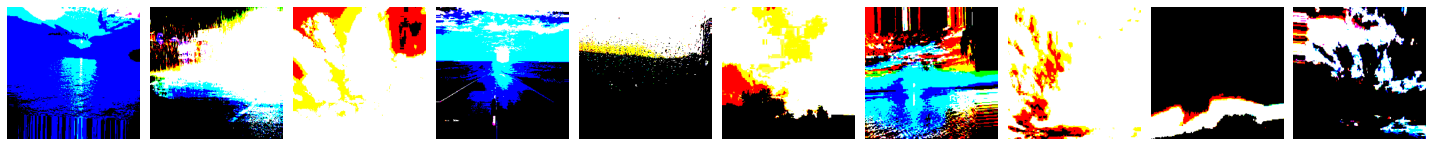

[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


In [25]:
plotImages(imgs)
print(text_labels)

In [32]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(224, 224, 3), padding="same"),
    MaxPool2D(pool_size=(2,2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same"),
    MaxPool2D(pool_size=(2,2), strides=2),
    Flatten(),
    Dense(units=4, activation="softmax")
])

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 200704)            0         
                                                                 
 dense_1 (Dense)             (None, 4)                

In [34]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [35]:
model.fit(x=train_batches, steps_per_epoch=len(train_batches), validation_data=valid_batches, validation_steps=len(valid_batches), epochs=3, verbose=2, batch_size=1)

Epoch 1/3
321/321 - 239s - loss: 6.7080 - accuracy: 0.8655 - val_loss: 4.4972 - val_accuracy: 0.9000 - 239s/epoch - 746ms/step
Epoch 2/3
321/321 - 239s - loss: 0.5852 - accuracy: 0.9569 - val_loss: 4.6952 - val_accuracy: 0.8850 - 239s/epoch - 744ms/step
Epoch 3/3
321/321 - 237s - loss: 0.2094 - accuracy: 0.9813 - val_loss: 3.9873 - val_accuracy: 0.8800 - 237s/epoch - 739ms/step


In [36]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [37]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[ 8 14 13 15]
 [14 14 12 10]
 [13 11  6 20]
 [13  8 14 15]]


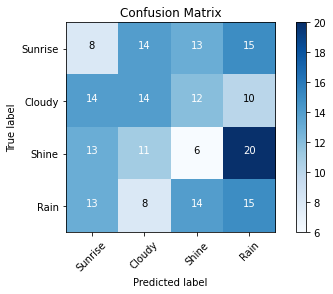

In [38]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
cm_plot_labels = ['Sunrise', 'Cloudy', 'Shine', 'Rain']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')